<a href="https://colab.research.google.com/github/samitha278/transformer-optim/blob/main/lora_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset prp

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


## Simple Neural Network

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super().__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

simple_nn = SimpleNN().to(device)

### vanila SGD from scratch - just to pracice

In [ ]:
class SGD:
    def __init__(self, parameters, lr: float = 0.01):

        self.params = parameters  # Store references to parameters
        self.lr = lr  # Learning rate

    def zero_grad(self):
        """Clear gradients of all parameters"""
        for param in self.params:
            # Check if parameter has gradients
            if param.grad is not None:
                # Set gradient tensor to zeros (in-place)
                param.grad.zero_()

    def step(self):
        """Update parameters using gradients"""
        for param in self.params:
            # Skip parameters without gradients
            if param.grad is None:
                continue

            # SGD update rule: param = param - lr * gradient
            # .data accesses the tensor data without affecting gradient computation
            param.data = param.data - self.lr * param.grad

## Trainer

In [ ]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_nn.parameters())
epochs = 1

losses = []
val_losses = []
j = 0

for i in range(epochs):

    simple_nn.train()          # activate train mode

    for x , y in iter(train_loader):
        x,y = x.to(device),y.to(device)  # move to device

        logits = simple_nn(x)
        loss = cross_el(logits,y)

        optimizer.zero_grad()  # param.grad = 0
        loss.backward()        # update param.grad
        optimizer.step()       # update param.data



        # validation
        if j%100==0:
            total_val_loss,k  = 0,0
            simple_nn.eval()

            with torch.no_grad():
                for a,b in iter(test_loader):
                    a,b = a.to(device),b.to(device)

                    out = simple_nn(a)
                    error = F.cross_entropy(out,b)

                    k+=1
                    total_val_loss+=error.item()

                val_losses.append(total_val_loss/k)
            simple_nn.train()


        # extra
        loss = loss.item()
        losses.append(loss)
        j+=1
        if j% 1000==0:
            print(f'{j} loss: {loss}')



1000 loss: 0.1601404994726181
2000 loss: 0.30196160078048706
3000 loss: 0.12890496850013733
4000 loss: 0.07935728132724762
5000 loss: 0.023920010775327682
6000 loss: 0.05955875664949417


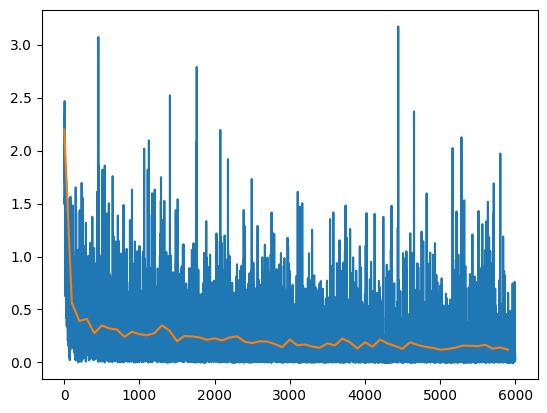

In [ ]:
plt.plot(losses)
plt.plot([i for i in range(0,6000,100)],val_losses)

### Save model

In [ ]:
# Save from any device
save_path = '/content/drive/MyDrive/model_weights.pth'
torch.save(simple_nn.state_dict(), save_path)

SimpleNN(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=2000, bias=True)
  (linear3): Linear(in_features=2000, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
# Load with device handling
loaded_model = SimpleNN()

# Load weights (map to current device)
state_dict = torch.load(save_path, map_location=device)
loaded_model.load_state_dict(state_dict)
loaded_model.to(device)

SimpleNN(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=2000, bias=True)
  (linear3): Linear(in_features=2000, out_features=10, bias=True)
  (relu): ReLU()
)

### Test loaded model

In [ ]:
def test(model):

    model.eval()

    total = 0
    correct = 0

    wrong_counts = [0 for i in range(10)]

    for x,y in iter(test_loader):
        x,y = x.to(device) , y.to(device)

        logits = model(x)
        predicts = torch.argmax(logits,dim=-1)

        for i,predict in enumerate(predicts):
            if predict==y[i] :
                correct+=1
            else:
                wrong_counts[y[i]]+=1
            total+=1

    accuracy = correct/total
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')


test(loaded_model)

wrong counts for the digit 0: 15
wrong counts for the digit 1: 8
wrong counts for the digit 2: 34
wrong counts for the digit 3: 29
wrong counts for the digit 4: 50
wrong counts for the digit 5: 63
wrong counts for the digit 6: 38
wrong counts for the digit 7: 52
wrong counts for the digit 8: 59
wrong counts for the digit 9: 26


---
### some tests model's attributes

In [ ]:
simple_nn.state_dict().keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [ ]:
next(iter(simple_nn.parameters()))

Parameter containing:
tensor([[ 0.0031,  0.0579,  0.0253,  ...,  0.0152,  0.0460,  0.0665],
        [ 0.0492, -0.0016,  0.0052,  ...,  0.0278, -0.0033,  0.0608],
        [-0.0084,  0.0394,  0.0375,  ...,  0.0200,  0.0069,  0.0028],
        ...,
        [ 0.0701,  0.0314,  0.0193,  ...,  0.0833,  0.0388,  0.0188],
        [ 0.0326, -0.0056,  0.0415,  ...,  0.0496, -0.0123,  0.0147],
        [ 0.0119, -0.0128,  0.0158,  ...,  0.0342, -0.0056, -0.0076]],
       device='cuda:0', requires_grad=True)

In [ ]:
next(iter(simple_nn.named_parameters()))     # contain name

('linear1.weight',
 Parameter containing:
 tensor([[ 0.0031,  0.0579,  0.0253,  ...,  0.0152,  0.0460,  0.0665],
         [ 0.0492, -0.0016,  0.0052,  ...,  0.0278, -0.0033,  0.0608],
         [-0.0084,  0.0394,  0.0375,  ...,  0.0200,  0.0069,  0.0028],
         ...,
         [ 0.0701,  0.0314,  0.0193,  ...,  0.0833,  0.0388,  0.0188],
         [ 0.0326, -0.0056,  0.0415,  ...,  0.0496, -0.0123,  0.0147],
         [ 0.0119, -0.0128,  0.0158,  ...,  0.0342, -0.0056, -0.0076]],
        device='cuda:0', requires_grad=True))

In [ ]:
next(iter(simple_nn.named_modules()))     # contain name

('',
 SimpleNN(
   (linear1): Linear(in_features=784, out_features=1000, bias=True)
   (linear2): Linear(in_features=1000, out_features=2000, bias=True)
   (linear3): Linear(in_features=2000, out_features=10, bias=True)
   (relu): ReLU()
 ))

---
# LoRA

In [5]:
class LoRALayer(nn.Module):

    def __init__(self,fan_in , fan_out, r=1,alpha=1 ):
        super().__init__()

        # random Gaussian initialization for A and zero for B
        # ∆W = BA is zero at the beginning of training

        self.A = nn.Parameter(torch.randn(r,fan_out))
        self.B = nn.Parameter(torch.zeros(fan_in,r))

        self.scale = alpha / r
        self.enabled = True


    def forward(self,original_weights):

        if self.enabled:

            d_w = self.scale* (self.B @ self.A)
            return original_weights + d_w.T

        return original_weights


In [ ]:
# lora layer test

layer1_w = simple_nn.linear1.weight
print(layer1_w.shape)

i,o = layer1_w.T.shape

lora1 = LoRALayer(i,o)

param1 = lora1.__dict__['_parameters']
A1,B1 = param1['A'], param1['B']

A1.shape,B1.shape,(B1@A1).shape

torch.Size([1000, 784])


(torch.Size([1, 1000]), torch.Size([784, 1]), torch.Size([784, 1000]))

---
### some tests model's dictionary

In [ ]:
detail_dict = simple_nn.__dict__
detail_dict

{'training': True,
 '_parameters': {},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': {'linear1': Linear(in_features=784, out_features=1000, bias=True),
  'linear2': Linear(in_features=1000, out_features=2000, bias=True),
  'linear3': Linear(in_features=2000, out_features=10, bias=True),
  'relu': ReLU()}}

In [ ]:
full_dict = simple_nn.__dict__['_modules']

# full_dict['linear1'].__dict__      # contains all info of Linear layer

config = {}
for name , module in simple_nn.__dict__['_modules'].items():
    if isinstance(module,nn.Linear):
        print(module)
        config[name] = (module.in_features,module.out_features)

config

Linear(in_features=784, out_features=1000, bias=True)
Linear(in_features=1000, out_features=2000, bias=True)
Linear(in_features=2000, out_features=10, bias=True)


{'linear1': (784, 1000), 'linear2': (1000, 2000), 'linear3': (2000, 10)}

In [ ]:
simple_nn.state_dict().keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [ ]:
w,b = loaded_model.linear1.parameters()
w

Parameter containing:
tensor([[ 0.0031,  0.0579,  0.0253,  ...,  0.0152,  0.0460,  0.0665],
        [ 0.0492, -0.0016,  0.0052,  ...,  0.0278, -0.0033,  0.0608],
        [-0.0084,  0.0394,  0.0375,  ...,  0.0200,  0.0069,  0.0028],
        ...,
        [ 0.0701,  0.0314,  0.0193,  ...,  0.0833,  0.0388,  0.0188],
        [ 0.0326, -0.0056,  0.0415,  ...,  0.0496, -0.0123,  0.0147],
        [ 0.0119, -0.0128,  0.0158,  ...,  0.0342, -0.0056, -0.0076]],
       device='cuda:0', requires_grad=True)

---

## NN with LoRA

In [ ]:
class SimpleNNLoRA(nn.Module):

    def __init__(self,config,model):
        super().__init__()

        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False

        l1_in , l1_out = config['linear1']
        self.lora1 = LoRALayer(l1_in,l1_out)

        l2_in , l2_out = config['linear2']
        self.lora2 = LoRALayer(l2_in,l2_out)

        l3_in , l3_out = config['linear3']
        self.lora3 = LoRALayer(l3_in,l3_out)

        self.relu = nn.ReLU()


    def forward(self,img):

        w1,b1 = self.model.linear1.parameters()
        w2,b2 = self.model.linear2.parameters()
        w3,b3 = self.model.linear3.parameters()

        x = img.view(-1,28*28)

        x = self.relu(torch.matmul(x,self.lora1(w1).T) + b1)
        x = self.relu(torch.matmul(x,self.lora2(w2).T) + b2)
        x = torch.matmul(x,self.lora3(w3).T) + b3

        return x



### Create Lora wrapper model

In [ ]:
config = {}
for name , module in loaded_model.__dict__['_modules'].items():
    if isinstance(module,nn.Linear):
        # print(module)
        config[name] = (module.in_features,module.out_features)

# create model
simple_nn_with_lora = SimpleNNLoRA(config,loaded_model).to(device)

In [ ]:
simple_nn_with_lora.__dict__.keys()    # now only train LoRA params

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules'])

In [ ]:
simple_nn_with_lora.__dict__['_modules']

{'model': SimpleNN(
   (linear1): Linear(in_features=784, out_features=1000, bias=True)
   (linear2): Linear(in_features=1000, out_features=2000, bias=True)
   (linear3): Linear(in_features=2000, out_features=10, bias=True)
   (relu): ReLU()
 ),
 'lora1': LoRALayer(),
 'lora2': LoRALayer(),
 'lora3': LoRALayer(),
 'relu': ReLU()}

In [ ]:
simple_nn_with_lora.__dict__['_modules']['lora1'].__dict__['_parameters'].keys()

dict_keys(['A', 'B'])

### Testing with pretrained weights but with Lora wrapper

In [ ]:
torch.manual_seed(278)
x = torch.randn((2,784)).to(device)

out = simple_nn_with_lora(x)

torch.argmax(out,dim=-1)

tensor([0, 5], device='cuda:0')

### Train lora wrapper - finetune for number 7

In [8]:
# Load the MNIST dataset again, by keeping only the digit 7
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
indices = mnist_trainset.targets == 7
mnist_trainset.data = mnist_trainset.data[indices]
mnist_trainset.targets = mnist_trainset.targets[indices]
# Create a dataloader for the training
train_loader_7 = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

In [ ]:
optimizer = torch.optim.AdamW(simple_nn_with_lora.parameters())
cross_el = nn.CrossEntropyLoss()

for i in range(1000):
    x,y = next(iter(train_loader_7))
    x,y = x.to(device),y.to(device)

    logits = simple_nn_with_lora(x)
    loss = cross_el(logits,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100==0 :
        print(f'{i}, {loss.item()}')

0, 0.005316582508385181
100, 0.0
200, 1.0728830091011332e-07
300, 0.0
400, 0.0006410511559806764
500, 0.0
600, 1.192092824453539e-08
700, 0.0
800, 5.960462701182223e-08
900, 0.0


### test fine tuned model

In [ ]:
# when lora enable
test(simple_nn_with_lora)

wrong counts for the digit 0: 980
wrong counts for the digit 1: 1124
wrong counts for the digit 2: 1032
wrong counts for the digit 3: 1010
wrong counts for the digit 4: 981
wrong counts for the digit 5: 763
wrong counts for the digit 6: 85
wrong counts for the digit 7: 0
wrong counts for the digit 8: 587
wrong counts for the digit 9: 1009


### lora disable

In [ ]:
# this must same as our simple_nn model results
simple_nn_with_lora.lora1.enabled=False
simple_nn_with_lora.lora2.enabled=False
simple_nn_with_lora.lora3.enabled=False

print(simple_nn_with_lora.__dict__['_modules']['lora1'].enabled)

test(simple_nn_with_lora)

False
wrong counts for the digit 0: 15
wrong counts for the digit 1: 8
wrong counts for the digit 2: 34
wrong counts for the digit 3: 29
wrong counts for the digit 4: 50
wrong counts for the digit 5: 63
wrong counts for the digit 6: 38
wrong counts for the digit 7: 52
wrong counts for the digit 8: 59
wrong counts for the digit 9: 26


---
## Testing how param updating

- without freeze model can it do only by optimizer?

In [19]:
class SimpleNNLoRA_v2(nn.Module):

    def __init__(self,config,model):
        super().__init__()

        self.model = model

        # not freeze -------------------------
        # for param in self.model.parameters():
        #     param.requires_grad = False

        l1_in , l1_out = config['linear1']
        self.lora1 = LoRALayer(l1_in,l1_out)

        l2_in , l2_out = config['linear2']
        self.lora2 = LoRALayer(l2_in,l2_out)

        l3_in , l3_out = config['linear3']
        self.lora3 = LoRALayer(l3_in,l3_out)

        self.relu = nn.ReLU()


    def forward(self,img):

        w1,b1 = self.model.linear1.parameters()
        w2,b2 = self.model.linear2.parameters()
        w3,b3 = self.model.linear3.parameters()

        x = img.view(-1,28*28)

        x = self.relu(torch.matmul(x,self.lora1(w1).T) + b1)
        x = self.relu(torch.matmul(x,self.lora2(w2).T) + b2)
        x = torch.matmul(x,self.lora3(w3).T) + b3

        return x

In [20]:
# Load with device handling
loaded_model_v2 = SimpleNN()

# Load weights (map to current device)
state_dict = torch.load('/content/drive/MyDrive/model_weights.pth', map_location=device)
loaded_model_v2.load_state_dict(state_dict)
loaded_model_v2.to(device)

SimpleNN(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=2000, bias=True)
  (linear3): Linear(in_features=2000, out_features=10, bias=True)
  (relu): ReLU()
)

In [14]:
config = {}
for name , module in loaded_model_v2.__dict__['_modules'].items():
    if isinstance(module,nn.Linear):
        config[name] = (module.in_features,module.out_features)

# create model
simple_nn_with_lora_v2 = SimpleNNLoRA_v2(config,loaded_model_v2).to(device)

In [27]:
optimizer = torch.optim.AdamW([p for param in simple_nn_with_lora_v2.modules() if isinstance(param,LoRALayer) for p in param.parameters()])
cross_el = nn.CrossEntropyLoss()

for i in range(1000):
    x,y = next(iter(train_loader_7))
    x,y = x.to(device),y.to(device)

    logits = simple_nn_with_lora_v2(x)
    loss = cross_el(logits,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%100==0 :
        print(f'{i}, {loss.item()}')

0, 0.16264227032661438
100, 0.01466198731213808
200, 5.044096542405896e-05
300, 2.4029708583839238e-05
400, 3.541289333952591e-05
500, 3.2305197237292305e-06
600, 0.0
700, 7.486063168471446e-06
800, 0.0
900, 0.0


In [29]:
# when lora enable
def test(model):

    model.eval()

    total = 0
    correct = 0

    wrong_counts = [0 for i in range(10)]

    for x,y in iter(test_loader):
        x,y = x.to(device) , y.to(device)

        logits = model(x)
        predicts = torch.argmax(logits,dim=-1)

        for i,predict in enumerate(predicts):
            if predict==y[i] :
                correct+=1
            else:
                wrong_counts[y[i]]+=1
            total+=1

    accuracy = correct/total
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')

test(simple_nn_with_lora_v2)

wrong counts for the digit 0: 826
wrong counts for the digit 1: 1134
wrong counts for the digit 2: 1028
wrong counts for the digit 3: 966
wrong counts for the digit 4: 982
wrong counts for the digit 5: 123
wrong counts for the digit 6: 54
wrong counts for the digit 7: 0
wrong counts for the digit 8: 974
wrong counts for the digit 9: 1009


In [30]:
# check that if params changed of base model
next(iter(loaded_model_v2.named_parameters()))

('linear1.weight',
 Parameter containing:
 tensor([[ 0.0031,  0.0579,  0.0253,  ...,  0.0152,  0.0460,  0.0665],
         [ 0.0492, -0.0016,  0.0052,  ...,  0.0278, -0.0033,  0.0608],
         [-0.0084,  0.0394,  0.0375,  ...,  0.0200,  0.0069,  0.0028],
         ...,
         [ 0.0701,  0.0314,  0.0193,  ...,  0.0833,  0.0388,  0.0188],
         [ 0.0326, -0.0056,  0.0415,  ...,  0.0496, -0.0123,  0.0147],
         [ 0.0119, -0.0128,  0.0158,  ...,  0.0342, -0.0056, -0.0076]],
        device='cuda:0', requires_grad=True))

- Only trained lora params when if requires_grad true in base model params
but calculate grad extra computation only update lora params
---